<a href="https://colab.research.google.com/github/Carlos-Pessin/FraudPrediction_PySpark_SparkML/blob/main/Case_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PIX Transactions Analysis**

## Objectives
Clean and preprocess PIX transaction data
Analyze PIX usage patterns, such as the most used channels and the most common transaction values
Use PySpark MLlib to train and evaluate a fraud detection model
Evaluate the model's performance and provide recommendations for future improvements

## Data
The dataset includes the following information for each transaction:

Transaction details: amount, time, sender and receiver CPF/CNPJ, type
Fraud label: a binary variable indicating whether the transaction was fraudulent (1) or not (0)

## Tasks

### Data Normalization:
The dataset you will read is in JSON format.
 {
      "id_transacao": int,
      "valor": string,
      "remetente": {
          "nome": string,
          "banco": string,
          "tipo": string
      },
      "destinatario": {
          "nome": string,
          "banco":string,
          "tipo": string
      },          
      "categoria":string,
      "chave_pix":string,
      "transaction_date":string,
      "fraude":int,
  }

  - Transform it into a columnar format

### Exploratory Data Analysis:
Use PySpark to analyze PIX usage patterns:
- most used PIX keys;
- most common transaction values;
- distribution of transaction values by hour and day;
- which banks received the most transfers per day;
- to which type of person (PF or PJ) more transactions were made

### Feature Engineering:
Present new features that may be useful for fraud detection, such as the number of transactions made by the same sender within a specific time period.

### Modeling:
Use PySpark MLlib to train and detect potential fraudulent transactions.

## Notes
- It is important to note that this is a simplified case, and in real-world scenarios, you would have to deal with more complex data, use more advanced techniques like ensemble methods, and consider domain knowledge as well as laws and regulations of financial institutions in Brazil.

- There is no 100% correct answer. You need to use your critical thinking to define the best metrics and analyses for the case.



## Business Understanding
You work at a bank where the primary payment method used is Pix.

Using the Pix transaction database, the bank wants to understand the profile of customers who use Pix, as well as identify potential fraudulent transactions. However, there is one specific customer who has a very good relationship with the bank. Therefore, you have received the customer's transaction data for the past two years and need to create a report containing the main characteristics of these transactions.

To summarize, we have two main objectives for this case:

### Extract value from the data
- To which bank does this customer transfer the most?
- What is the number of transfers made by this customer over time?
- Based on the value of the transfers, could a credit increase be justified?
- What does this customer use transfers for the most?

Implement a machine learning algorithm to identify potential fraudulent transactions.

## Post-Processing
Define at least five quality metrics for your data.

Explain whether your data is of good quality.

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=4e7c41cb1a155d74dbb647bf2e82b67eb6be95f684cfa1ca231529e6ff1bf8f8
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
!pip install pyngrok

In [191]:
!pip install pydeequ==1.0.1

  Attempting uninstall: pydeequ
    Found existing installation: pydeequ 1.4.0
    Uninstalling pydeequ-1.4.0:
      Successfully uninstalled pydeequ-1.4.0


In [1]:
!wget -qnc https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-windows-amd64.zip
!unzip -n -q ngrok-v3-stable-windows-amd64.zip

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics
from pyngrok import ngrok
import matplotlib.pyplot as plt
import seaborn as sns
import pydeequ
from pydeequ.analyzers import *
from pydeequ.suggestions import *
from pydeequ.verification import *
from pydeequ.checks import Check, CheckLevel, ConstrainableDataTypes

ERROR:logger:Please set env variable SPARK_VERSION


In [3]:
spark = (
    SparkSession.builder
      .config('spark.ui.port', '4050')
      .config("spark.jars.packages", pydeequ.deequ_maven_coord)
      .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
      .appName("SparkML Case")
      .getOrCreate()
)

In [4]:
!ngrok config add-authtoken 2lKu62Y5y2QKTzUBH0zed1BvC2R_6gZGxyJ8mbx9n75pSUkHq

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [5]:
public_url = ngrok.connect(4050)

In [ ]:
#!ngrok http http://localhost:4050

In [6]:
schema_remetente_destinatario = StructType([
    StructField('nome', StringType()),
    StructField('banco', StringType()),
    StructField('tipo', StringType()),
])


schema_base_pix = StructType([
    StructField('id_transacao', IntegerType()),
    StructField('valor', DoubleType()),
    StructField('remetente', schema_remetente_destinatario),
    StructField('destinatario', schema_remetente_destinatario),
    StructField('transaction_date', TimestampType()),
    StructField('chave_pix', StringType()),
    StructField('categoria', StringType()),
    StructField('fraude', IntegerType())
])

In [7]:
df = spark.read.json(
    '/content/drive/MyDrive/Colab Notebooks/Formação em dados/Spark/Datasets/case_final.json',
    schema=schema_base_pix,
    timestampFormat="yyyy-MM-dd HH:mm:ss"
)

## Data Understanding

In [8]:
df.printSchema(),
df.show()

root
 |-- id_transacao: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- remetente: struct (nullable = true)
 |    |-- nome: string (nullable = true)
 |    |-- banco: string (nullable = true)
 |    |-- tipo: string (nullable = true)
 |-- destinatario: struct (nullable = true)
 |    |-- nome: string (nullable = true)
 |    |-- banco: string (nullable = true)
 |    |-- tipo: string (nullable = true)
 |-- transaction_date: timestamp (nullable = true)
 |-- chave_pix: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- fraude: integer (nullable = true)

+------------+------------------+--------------------+--------------------+-------------------+---------+-------------+------+
|id_transacao|             valor|           remetente|        destinatario|   transaction_date|chave_pix|    categoria|fraude|
+------------+------------------+--------------------+--------------------+-------------------+---------+-------------+------+
|        1000|            

In [9]:
df_flat = df.withColumns({
        'destinatario_nome': col('destinatario').getField('nome'),
        'destinatario_banco': col('destinatario').getField('banco'),
        'destinatario_tipo': col('destinatario').getField('tipo'),
        'remetente_nome': col('remetente').getField('nome'),
        'remetente_banco': col('remetente').getField('banco'),
        'remetente_tipo': col('remetente').getField('tipo')
    }).drop('destinatario', 'remetente')

In [10]:
df_flat.printSchema(),
df_flat.show(5)

root
 |-- id_transacao: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- transaction_date: timestamp (nullable = true)
 |-- chave_pix: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- fraude: integer (nullable = true)
 |-- destinatario_nome: string (nullable = true)
 |-- destinatario_banco: string (nullable = true)
 |-- destinatario_tipo: string (nullable = true)
 |-- remetente_nome: string (nullable = true)
 |-- remetente_banco: string (nullable = true)
 |-- remetente_tipo: string (nullable = true)

+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+
|id_transacao|             valor|   transaction_date|chave_pix|    categoria|fraude|   destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|
+------------+------------------+-------------------+---------+----

In [11]:
df_flat.describe().show()

+-------+-----------------+------------------+---------+-----------+------------------+-----------------+------------------+-----------------+------------------+---------------+--------------+
|summary|     id_transacao|             valor|chave_pix|  categoria|            fraude|destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|
+-------+-----------------+------------------+---------+-----------+------------------+-----------------+------------------+-----------------+------------------+---------------+--------------+
|  count|           100000|            100000|   100000|     100000|            100000|           100000|            100000|           100000|            100000|         100000|        100000|
|   mean|          50999.5|10303.358732200059|     NULL|       NULL|           0.15367|             NULL|              NULL|             NULL|              NULL|           NULL|          NULL|
| stddev|28867.65779668774| 20874.9

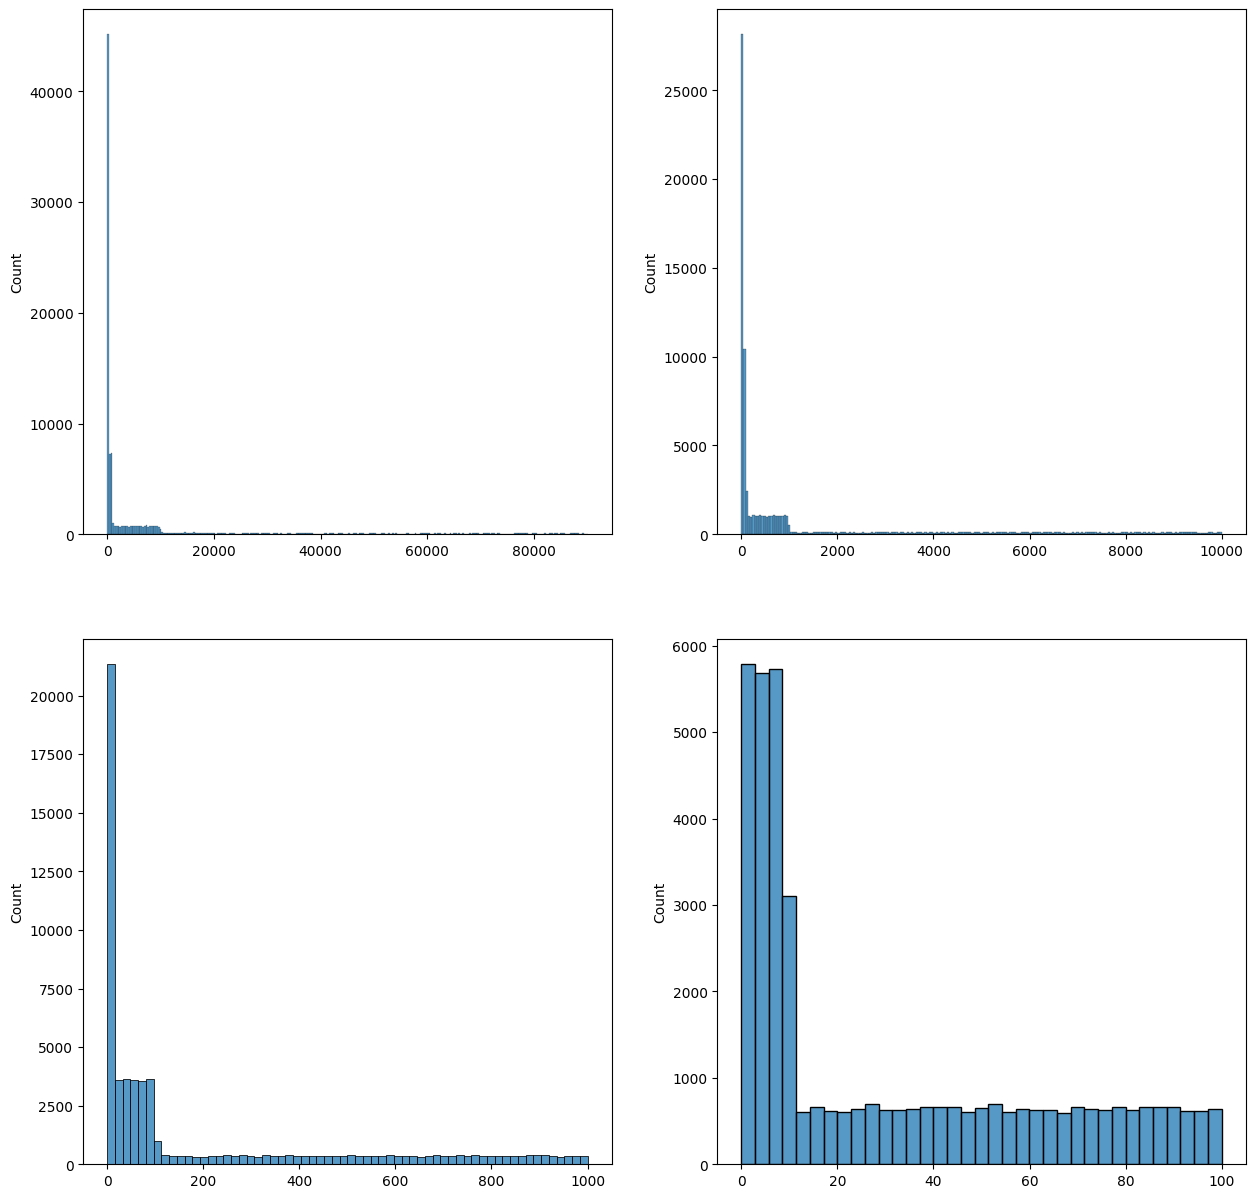

In [12]:
value_list = df_flat.select("valor").rdd.flatMap(lambda x: x).collect()


plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
sns.histplot(value_list)

plt.subplot(2,2,2)
value_list= [val for val in value_list if val <= 10000]
sns.histplot(value_list)

plt.subplot(2,2,3)
value_list= [val for val in value_list if val <= 1000]
sns.histplot(value_list)

plt.subplot(2,2,4)
value_list= [val for val in value_list if val <= 100]
sns.histplot(value_list)

plt.show()

Quality Analysis

In [13]:
df_flat.show(5)

+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+
|id_transacao|             valor|   transaction_date|chave_pix|    categoria|fraude|   destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|
+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+
|        1000|            588.08|2021-07-16 05:00:55|aleatoria|       outros|     0|         Calebe Melo|             Caixa|               PF|Jonathan Gonsalves|            BTG|            PF|
|        1001|           80682.5|2022-04-20 12:34:01|  celular|transferencia|     1|  Davi Lucas Pereira|             Caixa|               PJ|Jonathan Gonsalves|            BTG|            PF|
|        1002|             549.9|20

In [14]:
df_flat.select("categoria").distinct().show()

+-------------+
|    categoria|
+-------------+
|        saude|
|        lazer|
|    presentes|
|transferencia|
|    vestuario|
|  alimentacao|
|       outros|
|   transporte|
|     educacao|
+-------------+



In [23]:
df_flat.columns

['id_transacao',
 'valor',
 'transaction_date',
 'chave_pix',
 'categoria',
 'fraude',
 'destinatario_nome',
 'destinatario_banco',
 'destinatario_tipo',
 'remetente_nome',
 'remetente_banco',
 'remetente_tipo']

In [24]:
analysisResult = (
    AnalysisRunner(spark).onData(df_flat)
    .addAnalyzer(Size())
    .addAnalyzer(Completeness('transaction_date'))
    .addAnalyzer(Completeness('valor'))
    .addAnalyzer(Completeness('chave_pix'))
    .addAnalyzer(Completeness('categoria'))
    .addAnalyzer(Completeness('fraude'))
    .addAnalyzer(Completeness('remetente_nome'))
    .addAnalyzer(Completeness('remetente_banco'))
    .addAnalyzer(Completeness('remetente_tipo'))
    .addAnalyzer(Compliance('valor', 'valor>0'))
    .addAnalyzer(Compliance('fraude', 'fraude==0 or fraude==1'))
    .addAnalyzer(Compliance('chave_pix', 'chave_pix=="aleatoria" or chave_pix=="celular" or chave_pix=="email" or chave_pix=="cpf"'))
    .addAnalyzer(Compliance('remetente_tipo', 'remetente_tipo=="PF" or remetente_tipo=="PJ"'))
    .run()
)

In [25]:
analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show()

+-------+----------------+------------+--------+
| entity|        instance|        name|   value|
+-------+----------------+------------+--------+
| Column|  remetente_tipo|  Compliance|     1.0|
| Column|          fraude|  Compliance|     1.0|
| Column|       chave_pix|Completeness|     1.0|
| Column|  remetente_nome|Completeness|     1.0|
| Column|       chave_pix|  Compliance|     1.0|
| Column|           valor|Completeness|     1.0|
| Column|  remetente_tipo|Completeness|     1.0|
|Dataset|               *|        Size|100000.0|
| Column| remetente_banco|Completeness|     1.0|
| Column|          fraude|Completeness|     1.0|
| Column|transaction_date|Completeness|     1.0|
| Column|           valor|  Compliance| 0.99972|
| Column|       categoria|Completeness|     1.0|
+-------+----------------+------------+--------+



/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [32]:
print(df_flat.filter(col('valor') <= 0).count())
df_flat.filter(col('valor') <= 0).show()

28
+------------+-----+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+
|id_transacao|valor|   transaction_date|chave_pix|    categoria|fraude|   destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|
+------------+-----+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+
|        5662|  0.0|2021-12-21 17:33:59|    email|transferencia|     0|       Matheus Rocha|             Caixa|               PF|Jonathan Gonsalves|            BTG|            PF|
|        6070|  0.0|2021-02-16 07:33:02|      cpf|   transporte|     0|      Barbara Araujo|          Bradesco|               PJ|Jonathan Gonsalves|            BTG|            PF|
|        6117|  0.0|2021-09-29 17:08:45|      cpf|        saude|     0|      Ryan Goncalves|     

In [33]:
df_flat = df_flat.filter(col('valor') > 0)

## Feature Engineering

In [34]:
df_cat = df_flat.withColumn(
    'value_range',
    when(col('valor') <= 10, '10-')
    .when((col('valor') > 10) & (col('valor') <= 100), '11-100')
    .when((col('valor') > 101) & (col('valor') <= 1000), '101-1000')
    .when((col('valor') > 1000) & (col('valor') <= 10000), '1001-10000')
    .otherwise('10000+')
)
df_cat.show()

+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+-----------+
|id_transacao|             valor|   transaction_date|chave_pix|    categoria|fraude|   destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|value_range|
+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+-----------+
|        1000|            588.08|2021-07-16 05:00:55|aleatoria|       outros|     0|         Calebe Melo|             Caixa|               PF|Jonathan Gonsalves|            BTG|            PF|   101-1000|
|        1001|           80682.5|2022-04-20 12:34:01|  celular|transferencia|     1|  Davi Lucas Pereira|             Caixa|               PJ|Jonathan Gonsalves|            BTG|   

In [35]:
df_cat = df_cat.withColumn('hour', hour(col('transaction_date')))
df_cat.show(5)

+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+-----------+----+
|id_transacao|             valor|   transaction_date|chave_pix|    categoria|fraude|   destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|value_range|hour|
+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+-----------+----+
|        1000|            588.08|2021-07-16 05:00:55|aleatoria|       outros|     0|         Calebe Melo|             Caixa|               PF|Jonathan Gonsalves|            BTG|            PF|   101-1000|   5|
|        1001|           80682.5|2022-04-20 12:34:01|  celular|transferencia|     1|  Davi Lucas Pereira|             Caixa|               PJ|Jonathan Gonsalves

In [36]:
df_cat = df_cat.withColumn(
    'time_range',
    when((col('hour') < 5) | (col('hour') > 22), 'late-night')
    .when((col('hour') >= 5) & (col('hour') < 8), 'dawn')
    .when((col('hour') >= 8) & (col('hour') <= 18), 'work-hour')
    .otherwise('night')
)
df_cat.show()

+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+-----------+----+----------+
|id_transacao|             valor|   transaction_date|chave_pix|    categoria|fraude|   destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|value_range|hour|time_range|
+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+-----------+----+----------+
|        1000|            588.08|2021-07-16 05:00:55|aleatoria|       outros|     0|         Calebe Melo|             Caixa|               PF|Jonathan Gonsalves|            BTG|            PF|   101-1000|   5|      dawn|
|        1001|           80682.5|2022-04-20 12:34:01|  celular|transferencia|     1|  Davi Lucas Pereira|           

In [37]:
df_cat = df_cat.withColumn('day_of_week', dayofweek(col('transaction_date')))
df_cat.show()

+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+-----------+----+----------+-----------+
|id_transacao|             valor|   transaction_date|chave_pix|    categoria|fraude|   destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|value_range|hour|time_range|day_of_week|
+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+-----------+----+----------+-----------+
|        1000|            588.08|2021-07-16 05:00:55|aleatoria|       outros|     0|         Calebe Melo|             Caixa|               PF|Jonathan Gonsalves|            BTG|            PF|   101-1000|   5|      dawn|          6|
|        1001|           80682.5|2022-04-20 12:34:01|  celular|trans

In [38]:
df_cat = df_cat.withColumn('year_month', concat(year(col('transaction_date')), lit('-'), month(col('transaction_date'))))
df_cat.show()

+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+-----------+----+----------+-----------+----------+
|id_transacao|             valor|   transaction_date|chave_pix|    categoria|fraude|   destinatario_nome|destinatario_banco|destinatario_tipo|    remetente_nome|remetente_banco|remetente_tipo|value_range|hour|time_range|day_of_week|year_month|
+------------+------------------+-------------------+---------+-------------+------+--------------------+------------------+-----------------+------------------+---------------+--------------+-----------+----+----------+-----------+----------+
|        1000|            588.08|2021-07-16 05:00:55|aleatoria|       outros|     0|         Calebe Melo|             Caixa|               PF|Jonathan Gonsalves|            BTG|            PF|   101-1000|   5|      dawn|          6|    2021-7|
|        1001|          

In [39]:
df_cat.select('remetente_nome', 'remetente_banco', 'remetente_tipo').distinct().show()

+------------------+---------------+--------------+
|    remetente_nome|remetente_banco|remetente_tipo|
+------------------+---------------+--------------+
|Jonathan Gonsalves|            BTG|            PF|
+------------------+---------------+--------------+



In [40]:
df_cat = df_cat.drop('remetente_nome', 'remetente_banco', 'remetente_tipo')   # only one value

## Exploratory Analisys

- **Most used PIX keys:** email


In [41]:
df_cat.select('chave_pix').groupby('chave_pix').count().show()

+---------+-----+
|chave_pix|count|
+---------+-----+
|aleatoria|24806|
|  celular|24852|
|    email|25206|
|      cpf|25108|
+---------+-----+



- **Most common transaction values:** Between 11 and 100 reais

In [42]:
df_cat.select('valor').groupby('valor').count().sort('count', ascending=False).show()

+-----+-----+
|valor|count|
+-----+-----+
| 8.36|   36|
| 4.84|   35|
| 8.49|   33|
| 2.07|   33|
| 5.26|   33|
| 7.25|   32|
| 7.69|   32|
| 5.89|   32|
| 2.32|   32|
| 5.59|   32|
| 5.07|   32|
|  0.4|   31|
| 1.44|   31|
| 9.22|   30|
| 7.04|   30|
| 2.55|   30|
| 7.11|   30|
| 4.62|   30|
| 1.21|   30|
| 4.16|   29|
+-----+-----+
only showing top 20 rows



In [43]:
df_cat.select('value_range').groupby('value_range').count().show()

+-----------+-----+
|value_range|count|
+-----------+-----+
|        10-|19996|
|     11-100|20111|
|   101-1000|19994|
| 1001-10000|20081|
|     10000+|19790|
+-----------+-----+



- **Distribution of transaction values by hour and day:**

In [44]:
df_cat.select('day_of_week', 'time_range', 'value_range').groupby('day_of_week', 'time_range', 'value_range').count().sort('day_of_week', 'time_range', 'value_range').show()

+-----------+----------+-----------+-----+
|day_of_week|time_range|value_range|count|
+-----------+----------+-----------+-----+
|          1|      dawn|        10-|  345|
|          1|      dawn|     10000+|  327|
|          1|      dawn| 1001-10000|  361|
|          1|      dawn|   101-1000|  337|
|          1|      dawn|     11-100|  367|
|          1|late-night|        10-|  705|
|          1|late-night|     10000+|  697|
|          1|late-night| 1001-10000|  697|
|          1|late-night|   101-1000|  703|
|          1|late-night|     11-100|  760|
|          1|     night|        10-|  471|
|          1|     night|     10000+|  459|
|          1|     night| 1001-10000|  489|
|          1|     night|   101-1000|  470|
|          1|     night|     11-100|  487|
|          1| work-hour|        10-| 1275|
|          1| work-hour|     10000+| 1266|
|          1| work-hour| 1001-10000| 1295|
|          1| work-hour|   101-1000| 1339|
|          1| work-hour|     11-100| 1335|
+----------

- **Which banks received the most transfers per day:**


In [45]:
df_cat.select('day_of_week', 'destinatario_banco').groupby('day_of_week', 'destinatario_banco').count().sort('day_of_week', 'destinatario_banco').show()

+-----------+------------------+-----+
|day_of_week|destinatario_banco|count|
+-----------+------------------+-----+
|          1|               BTG| 2046|
|          1|          Bradesco| 1991|
|          1|                C6| 2007|
|          1|             Caixa| 2069|
|          1|              Itau| 2012|
|          1|            Nubank| 2020|
|          1|                XP| 2040|
|          2|               BTG| 2016|
|          2|          Bradesco| 2036|
|          2|                C6| 2077|
|          2|             Caixa| 2019|
|          2|              Itau| 1949|
|          2|            Nubank| 1977|
|          2|                XP| 2081|
|          3|               BTG| 2066|
|          3|          Bradesco| 2002|
|          3|                C6| 2044|
|          3|             Caixa| 2058|
|          3|              Itau| 2041|
|          3|            Nubank| 1986|
+-----------+------------------+-----+
only showing top 20 rows



- **To which type of person (PF or PJ) more transactions were made:** PJ

In [46]:
df_cat.select('destinatario_tipo').groupby('destinatario_tipo').count().show()

+-----------------+-----+
|destinatario_tipo|count|
+-----------------+-----+
|               PF|49739|
|               PJ|50233|
+-----------------+-----+



- **To which bank does this customer transfer the most?:** XP


In [47]:
df_cat.select('destinatario_banco').groupby('destinatario_banco').count().sort('count', ascending=False).show()

+------------------+-----+
|destinatario_banco|count|
+------------------+-----+
|                XP|14399|
|               BTG|14389|
|            Nubank|14292|
|              Itau|14279|
|             Caixa|14233|
|                C6|14200|
|          Bradesco|14180|
+------------------+-----+



- **What is the number of transfers made by this customer over time?**

In [48]:
df_cat.select('year_month').groupby('year_month').count().sort('year_month').show()

+----------+-----+
|year_month|count|
+----------+-----+
|    2021-1| 2415|
|   2021-10| 4233|
|   2021-11| 4050|
|   2021-12| 4228|
|    2021-2| 3793|
|    2021-3| 4174|
|    2021-4| 4060|
|    2021-5| 4301|
|    2021-6| 4238|
|    2021-7| 4158|
|    2021-8| 4250|
|    2021-9| 4095|
|    2022-1| 4236|
|   2022-10| 4198|
|   2022-11| 4096|
|   2022-12| 4220|
|    2022-2| 3855|
|    2022-3| 4282|
|    2022-4| 4108|
|    2022-5| 4241|
+----------+-----+
only showing top 20 rows



In [49]:
df_cat.select('time_range').groupby('time_range').count().sort('count', ascending=False).show()

+----------+-----+
|time_range|count|
+----------+-----+
| work-hour|45802|
|late-night|24952|
|     night|16678|
|      dawn|12540|
+----------+-----+



In [50]:
df_cat.select('day_of_week').groupby('day_of_week').count().sort('count', ascending=False).show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|          6|14503|
|          5|14476|
|          7|14364|
|          3|14254|
|          1|14185|
|          2|14155|
|          4|14035|
+-----------+-----+



- **What category does this customer use transfers for the most?** Transfers

In [51]:
df_cat.select('categoria').groupby('categoria').count().sort('count', ascending=False).show()

+-------------+-----+
|    categoria|count|
+-------------+-----+
|transferencia|24743|
|  alimentacao| 9544|
|    vestuario| 9500|
|        saude| 9472|
|        lazer| 9463|
|     educacao| 9457|
|       outros| 9374|
|    presentes| 9250|
|   transporte| 9169|
+-------------+-----+



Looking for patherns in frauds

In [79]:
df_cat.select('categoria', 'fraude').groupby('categoria', 'fraude').count().sort('count', ascending=False).show()

+-------------+------+-----+
|    categoria|fraude|count|
+-------------+------+-----+
|transferencia|     1|15367|
|  alimentacao|     0| 9544|
|    vestuario|     0| 9500|
|        saude|     0| 9472|
|        lazer|     0| 9463|
|     educacao|     0| 9457|
|transferencia|     0| 9376|
|       outros|     0| 9374|
|    presentes|     0| 9250|
|   transporte|     0| 9169|
+-------------+------+-----+



In [82]:
df_cat.select('categoria', 'fraude', 'value_range').filter(col('fraude')==1).groupby('categoria', 'fraude', 'value_range').count().sort('count', ascending=False).show()

+-------------+------+-----------+-----+
|    categoria|fraude|value_range|count|
+-------------+------+-----------+-----+
|transferencia|     1|     10000+|15367|
+-------------+------+-----------+-----+



All frauds are from "transferencia" category and had value bigger than 10000

## Data preparation

Encoding

In [52]:
indexer = StringIndexer(
    inputCols=[
        'destinatario_banco',
        'destinatario_tipo',
        'chave_pix',
        'categoria',
        'value_range',
        'time_range',
        'year_month'
        ],
    outputCols=[
        'destinatario_banco_index',
        'destinatario_tipo_index',
        'chave_pix_index',
        'categoria_index',
        'value_range_index',
        'time_range_index',
        'year_month_index'
        ],
)

In [53]:
df_model = indexer.fit(df_cat).transform(df_cat)
df_model = df_model.drop(
        'destinatario_nome',    # too many values
        'destinatario_banco',
        'destinatario_tipo',
        'chave_pix',
        'categoria',
        'value_range',
        'time_range',
        'year_month',
        'id_transacao',
        'transaction_date',
        'hour',
        'valor'
        )

In [54]:
df_model.printSchema(),
df_model.show()

root
 |-- fraude: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- destinatario_banco_index: double (nullable = false)
 |-- destinatario_tipo_index: double (nullable = false)
 |-- chave_pix_index: double (nullable = false)
 |-- categoria_index: double (nullable = false)
 |-- value_range_index: double (nullable = false)
 |-- time_range_index: double (nullable = false)
 |-- year_month_index: double (nullable = false)

+------+-----------+------------------------+-----------------------+---------------+---------------+-----------------+----------------+----------------+
|fraude|day_of_week|destinatario_banco_index|destinatario_tipo_index|chave_pix_index|categoria_index|value_range_index|time_range_index|year_month_index|
+------+-----------+------------------------+-----------------------+---------------+---------------+-----------------+----------------+----------------+
|     0|          6|                     4.0|                    1.0|            3.0|       

In [55]:
df_model = (
            df_model.withColumn('destinatario_banco_index', col('destinatario_banco_index').cast('int'))
            .withColumn('destinatario_tipo_index', col('destinatario_tipo_index').cast('int'))
            .withColumn('chave_pix_index', col('chave_pix_index').cast('int'))
            .withColumn('categoria_index', col('categoria_index').cast('int'))
            .withColumn('value_range_index', col('value_range_index').cast('int'))
            .withColumn('time_range_index', col('time_range_index').cast('int'))
            .withColumn('year_month_index', col('year_month_index').cast('int'))
)

In [56]:
df_model.printSchema(),
df_model.show()

root
 |-- fraude: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- destinatario_banco_index: integer (nullable = true)
 |-- destinatario_tipo_index: integer (nullable = true)
 |-- chave_pix_index: integer (nullable = true)
 |-- categoria_index: integer (nullable = true)
 |-- value_range_index: integer (nullable = true)
 |-- time_range_index: integer (nullable = true)
 |-- year_month_index: integer (nullable = true)

+------+-----------+------------------------+-----------------------+---------------+---------------+-----------------+----------------+----------------+
|fraude|day_of_week|destinatario_banco_index|destinatario_tipo_index|chave_pix_index|categoria_index|value_range_index|time_range_index|year_month_index|
+------+-----------+------------------------+-----------------------+---------------+---------------+-----------------+----------------+----------------+
|     0|          6|                       4|                      1|              3|       

In [57]:
train, test = df_model.randomSplit([0.8, 0.2], seed=0)
train.count(), test.count()

(79812, 20160)

## Modeling

In [58]:
assembler = VectorAssembler(
    inputCols = [x for x in train.columns if x not in ['fraude']],
    outputCol = 'features'
)

Logistic Regression

In [59]:
lr = LogisticRegression().setParams(
    maxIter=100000,
    labelCol='fraude',
    predictionCol='prediction'
)

In [60]:
model = Pipeline(stages=[assembler, lr]).fit(train)

In [61]:
predicted = model.transform(test)

In [62]:
predicted.crosstab('fraude', 'prediction').show()

+-----------------+-----+----+
|fraude_prediction|  0.0| 1.0|
+-----------------+-----+----+
|                0|16951| 105|
|                1|    0|3104|
+-----------------+-----+----+



In [63]:
predictionAndLabels = predicted.select(col('prediction').cast('double'), col('fraude').cast('double')).rdd
metrics = MulticlassMetrics(predictionAndLabels)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [64]:
print(f'Accuracy: {metrics.accuracy}')
print(f'Precision: {metrics.precision(1)}')
print(f'Recall: {metrics.recall(1)}')

Accuracy: 0.9947916666666666
Precision: 0.9672795263321907
Recall: 1.0


Random Forest

In [65]:
rf = RandomForestClassifier().setParams(
    labelCol='fraude',
    predictionCol='prediction',
    maxDepth=5,
    numTrees=1000
)

In [66]:
model = Pipeline(stages=[assembler, rf]).fit(train)

In [67]:
predicted = model.transform(test)

In [68]:
predicted.crosstab('fraude', 'prediction').show() # confusionmatrix

+-----------------+-----+----+
|fraude_prediction|  0.0| 1.0|
+-----------------+-----+----+
|                0|16951| 105|
|                1|    0|3104|
+-----------------+-----+----+



In [69]:
predictionAndLabels = predicted.select(col('prediction').cast('double'), col('fraude').cast('double')).rdd
metrics = MulticlassMetrics(predictionAndLabels)

In [70]:
print(f'Accuracy: {metrics.accuracy}')
print(f'Precision: {metrics.precision(1)}')
print(f'Recall: {metrics.recall(1)}')

Accuracy: 0.9947916666666666
Precision: 0.9672795263321907
Recall: 1.0


In [71]:
model.stages[1].featureImportances

SparseVector(8, {0: 0.0001, 1: 0.0001, 2: 0.0, 3: 0.0001, 4: 0.3708, 5: 0.6287, 6: 0.0001, 7: 0.0001})

Removing less importante features and trying again

In [72]:
train0 = train.drop('day_of_week', 'destinatario_banco_index', 'destinatario_tipo_index',
                    'chave_pix_index', 'time_range_index', 'year_month_index')
test0 = test.drop('day_of_week', 'destinatario_banco_index', 'destinatario_tipo_index',
                    'chave_pix_index', 'time_range_index', 'year_month_index')

In [73]:
assembler = VectorAssembler(
    inputCols = [x for x in train0.columns if x not in ['fraude']],
    outputCol = 'features'
)

In [74]:
lr = LogisticRegression().setParams(
    maxIter=100000,
    labelCol='fraude',
    predictionCol='prediction'
)

In [75]:
model = Pipeline(stages=[assembler, rf]).fit(train0)

In [76]:
predicted = model.transform(test0)

In [77]:
predicted.crosstab('fraude', 'prediction').show() # confusionmatrix

+-----------------+-----+----+
|fraude_prediction|  0.0| 1.0|
+-----------------+-----+----+
|                0|16951| 105|
|                1|    0|3104|
+-----------------+-----+----+



In [78]:
predictionAndLabels = predicted.select(col('prediction').cast('double'), col('fraude').cast('double')).rdd
metrics = MulticlassMetrics(predictionAndLabels)
print(f'Accuracy: {metrics.accuracy}')
print(f'Precision: {metrics.precision(1)}')
print(f'Recall: {metrics.recall(1)}')

Accuracy: 0.9947916666666666
Precision: 0.9672795263321907
Recall: 1.0


The results were the same. We can now confirm that  category and value range are the predictors for fraud.


Better to use this second cause it demands less memory.

Evaluating time to predict

In [88]:
%%time
predicted = model.transform(test0.sample(False, 0.1, seed=0).limit(1))
predicted.show()

+------+---------------+-----------------+---------+-------------+-----------+----------+
|fraude|categoria_index|value_range_index| features|rawPrediction|probability|prediction|
+------+---------------+-----------------+---------+-------------+-----------+----------+
|     0|              1|                1|[1.0,1.0]| [1000.0,0.0]|  [1.0,0.0]|       0.0|
+------+---------------+-----------------+---------+-------------+-----------+----------+

CPU times: user 44.2 ms, sys: 5.27 ms, total: 49.5 ms
Wall time: 3.88 s


# **Final Report**

We could found that this client has a large amount of transfers, especially for PJ accounts. He may be using his personal account for business purposes, we may approach him to get a better understanding/account.

It was possible to identify that all frauds were made in transfer category and were worth more than 10.000. Therefore, we recommend to reduce his fixed limit to avoid frauds. Whenever he needs to transfer this values he can manually unblock.

Our Machine Learning model detected all frauds and had only 3,3% of false alerts. It runs in less than 4s.